### Deep Learning Notes 1
- *Автор*: Зитцер Данил
- *Дата*: вторник, 19 января 2021 г., 10:51:08
- *Описание*: Введение в модели машинного обучения и метрики качества задач классификации на примере решения задачи классификации рукописных цифр.
- *План блокнота*:
    - загрузка [набора данных MNIST](https://www.openml.org/d/554)
    - визуализация образцов из набора
    - решение задачи бинарной классификации (5 против остальных цифр)
    - вводная часть про баланс классов и метрики качества задач классификации (accuracy, precision, recall)
    - решение задачи многоклассовой классификации (каждая цифра против остальных) различными моделями МО
    - подбор оптимальных параметров лучшей модели

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from collections import Counter


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

plt.rcParams['figure.figsize'] = (18, 9)
plt.rcParams['font.size'] = 20

warnings.filterwarnings('ignore')

#### Загрузка набора данных

In [2]:
# загрузим набор данных
!wget https://www.openml.org/data/get_csv/52667/mnist_784.arff -O ./../data/mnist_784.csv

--2021-03-04 14:55:20--  https://www.openml.org/data/get_csv/52667/mnist_784.arff
Resolving www.openml.org (www.openml.org)... 131.155.11.11
Connecting to www.openml.org (www.openml.org)|131.155.11.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘./../data/mnist_784.csv’

./../data/mnist_784     [               <=>  ] 121,95M  10,4MB/s    in 24s     

2021-03-04 14:55:45 (4,98 MB/s) - ‘./../data/mnist_784.csv’ saved [127873961]



In [3]:
# проверим наличие
!ls -lh ./../data/

total 122M
-rw-rw-r-- 1 danil danil 2,8K мар  4 14:16 mlp_grid_search_results.csv
-rw-rw-r-- 1 danil danil 122M мар  4 14:55 mnist_784.csv
-rw-rw-r-- 1 danil danil 1,1K мар  4 14:16 models_battle_list.csv


#### Подготовка набора данных

In [4]:
mnist = pd.read_csv(filepath_or_buffer='./../data/mnist_784.csv')
mnist.head()

# последний столбец - это отклик, то есть содержит правильный ответ для изображения

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,...,pixel736,pixel737,pixel738,pixel739,pixel740,pixel741,pixel742,pixel743,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,14,147,252,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9


In [5]:
# отделим отклик от признаков
y = mnist.pop('class').to_numpy()
x = mnist.to_numpy()

print('x.shape', x.shape, x.dtype)
print('y.shape', y.shape, y.dtype)

del mnist

x.shape (70000, 784) int64
y.shape (70000,) int64


In [6]:
# взглянем на то, как представлена третья цифра в наборе данных
pd.DataFrame(x[2].reshape(28, 28))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,67,232,39,0,0,0,0,0
6,0,0,0,0,62,81,0,0,0,0,0,0,0,0,0,0,0,0,0,0,120,180,39,0,0,0,0,0
7,0,0,0,0,126,163,0,0,0,0,0,0,0,0,0,0,0,0,0,2,153,210,40,0,0,0,0,0
8,0,0,0,0,220,163,0,0,0,0,0,0,0,0,0,0,0,0,0,27,254,162,0,0,0,0,0,0
9,0,0,0,0,222,163,0,0,0,0,0,0,0,0,0,0,0,0,0,183,254,125,0,0,0,0,0,0


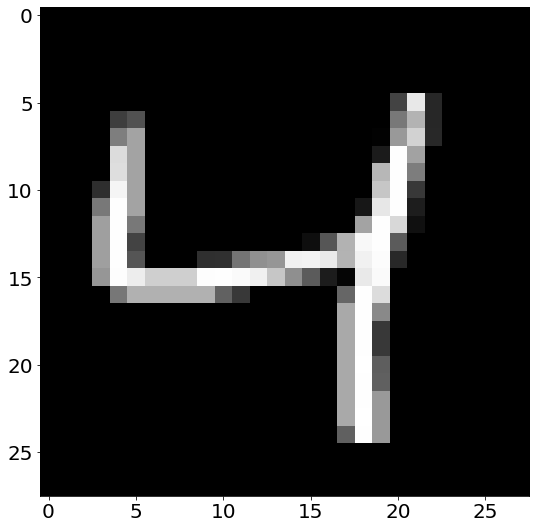

In [7]:
# визуализируем третью цифру
plt.imshow(x[2].reshape(28, 28), cmap='gray')

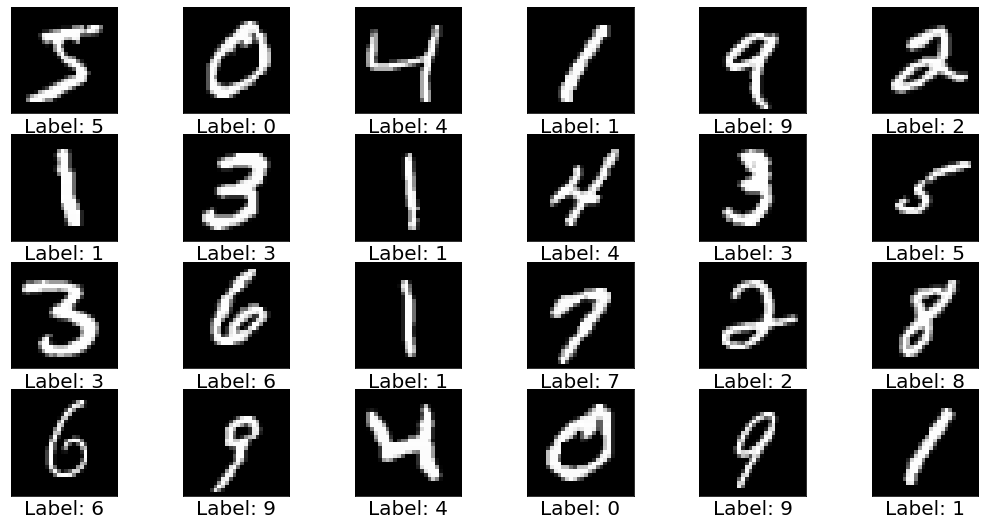

In [8]:
fig, axes = plt.subplots(4, 6)

for i, ax in enumerate(axes.flat):
    ax.imshow(x[i].reshape(28, 28), cmap='gray')
    ax.set(xticks=[], yticks=[], xlabel=f'Label: {y[i]}')

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [10]:
# разбиение выборки на обучающую и тестовую
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=10000, stratify=y)

# стандартизация данных
scaler = StandardScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

print('x_train_scaled.shape', x_train_scaled.shape, x_train_scaled.dtype)
print('y_train.shape', y_train.shape, y_train.dtype)
print()
print('x_test_scaled.shape', x_test_scaled.shape, x_test_scaled.dtype)
print('y_test.shape', y_test.shape, y_test.dtype)

# проверим баланс классов в обучающей и тестовой выборке
pd.concat(
    objs=[
        pd.Series(Counter(y_train), name='train'),
        pd.Series(Counter(y_test), name='test'),
    ],
    axis=1
).apply(lambda x: x / x.sum()).style.format('{:.2%}'.format)

x_train_scaled.shape (60000, 784) float64
y_train.shape (60000,) int64

x_test_scaled.shape (10000, 784) float64
y_test.shape (10000,) int64


,train,test
0,9.86%,9.86%
1,11.25%,11.25%
2,9.98%,9.99%
3,10.20%,10.20%
4,9.75%,9.75%
5,9.02%,9.02%
6,9.82%,9.82%
7,10.42%,10.42%
8,9.75%,9.75%
9,9.94%,9.94%


#### Обучение двоичного классификатора

In [11]:
# будем различать пятёрки от всех остальных цифр
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

![Logistis regression](https://www.machinelearningplus.com/wp-content/uploads/2017/09/linear_vs_logistic_regression.jpg)

In [12]:
# импорт модели логистической регрессии - бинарный классификатор
from sklearn.linear_model import LogisticRegression

In [13]:
# предскзывает вероятность положительного класса, то есть пятёрки
logreg = LogisticRegression(max_iter=50)
logreg.fit(x_train_scaled, y_train_5)

LogisticRegression(max_iter=50)

In [14]:
# импорт метрики - доля правильных ответов
from sklearn.metrics import accuracy_score

In [15]:
# пример расчёта доли правильных ответов
accuracy_score([True, False, True, False], [True, True, True, False])

0.75

In [16]:
y_test_pred_5 = logreg.predict(x_test_scaled)

accuracy_score(y_test_5, y_test_pred_5)

0.9743

Проведём оценку accuracy на разных фолдах внутри обучающей выборки.

Такая техника называется кросс-валидацией.

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

In [17]:
from sklearn.model_selection import cross_val_score

In [18]:
# посчитаем accuracy на 5 разных фолдах 
cross_val_score(
    estimator=LogisticRegression(max_iter=50, n_jobs=-1),
    X=x_train_scaled,
    y=y_train_5,
    scoring='accuracy',
    cv=5
)

array([0.97158333, 0.97625   , 0.97483333, 0.97575   , 0.97516667])

Dummy классификатор

In [19]:
from sklearn.dummy import DummyClassifier

In [20]:
# классификатор-болванка, будет всегда предсказывать, что на изображении видит не пятёрку
dummy_clf = DummyClassifier(strategy='constant', constant=False)

cross_val_score(
    estimator=dummy_clf,
    X=x_train_scaled,
    y=y_train_5,
    scoring='accuracy',
    cv=5
)

array([0.90983333, 0.90983333, 0.90983333, 0.90983333, 0.90975   ])

Как оказалось, даже такой "глупый" классификатор выдаёт 90% доли правильных ответов.

In [21]:
Counter(y_train_5)

Counter({False: 54589, True: 5411})

Всё дело в том, что в нашей выборке 90% не пятёрок и только 10% пятёрок.

Недостатки accuracy:
- не даёт объективной картины на несбалансированных выборках
- не учитывает разные веса разных типов ошибок

#### Матрица неточностей, точность и полнота

In [22]:
from sklearn.model_selection import cross_val_predict

In [23]:
# принцип у этой функции точно такой же как и у cross_val_score
# она для каждого фолда делает предсказания
y_train_pred_5_cv = cross_val_predict(
    estimator=LogisticRegression(max_iter=50),
    X=x_train_scaled,
    y=y_train_5,
    cv=5
)

In [24]:
from sklearn.metrics import confusion_matrix

[Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)

In [25]:
# матрица неточностей
TN, FP, FN, TP = confusion_matrix(y_train_5, y_train_pred_5_cv).ravel()

In [26]:
pd.DataFrame(
    data=[[TN, FP], [FN, TP]],
    index=pd.MultiIndex.from_tuples([('Actual', 'False'), ('Actual', 'True')]),
    columns=pd.MultiIndex.from_tuples([('Predicted', 'False'), ('Predicted', 'True')]),
)

Predicted      
                 False  True
Actual False     54053   536
       True        981  4430

[Accuracy, Precision, Recall](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/)

[Метрики в задачах машинного обучения](https://habr.com/ru/company/ods/blog/328372/)

![](https://images4.programmersought.com/832/0d/0d04e05551d02a4a9409d4fa4bff0fc0.png)

$$Accuracy = \frac{TP + TN}{TN + FP + FN + TP} - доля~правильных~ответов$$

$$Precision = \frac{TP}{TP + FP} - точность$$

$$Recall = \frac{TP}{TP + FN} - полнота$$

In [27]:
from sklearn.metrics import precision_score, recall_score

In [28]:
# точность
precision_score(y_train_5, y_train_pred_5_cv)

0.8920660491341119

In [29]:
# полнота
recall_score(y_train_5, y_train_pred_5_cv)

0.8187026427647385

#### Сравнение моделей

Устроим битву моделей. На этот раз будет решать задачу распознавания всех чисел.

[scikit-learn API Reference](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model)

- [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier)

- [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier)

- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

- [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier)

- [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)

- [RidgeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier)

- [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)

- [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)

- [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

In [30]:
from sklearn.model_selection import cross_validate

from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

[General principles scikit-learn Core API](https://arxiv.org/pdf/1309.0238.pdf)

Схематично обучение моделей машинного обучения выглядит вот так:

![](https://lms.skillfactory.ru/assets/courseware/v1/b89ec2f618cbfd8f9c9fc0320fca1033/asset-v1:Skillfactory+DL-WEEKLY+03APR2020+type@asset+block/DL_1_%D0%BC%D0%BE%D0%B4%D1%83%D0%BB%D1%8C_1_1.png)

**Устроим битву моделей**

**Не запускать! Расчёты длятся от 40 минут!**

In [31]:
list_of_models = [
    BaggingClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(),
    SGDClassifier(),
    LogisticRegression(),
    RidgeClassifier(),
    KNeighborsClassifier(),
    MLPClassifier(),
    DecisionTreeClassifier(),
]

list_of_model_names = [type(x).__name__ for x in list_of_models]

cv_results = pd.DataFrame(
    data=0.0,
    index=list_of_model_names,
    columns=['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro'],
)

# прогон всех моделей из списка
# =============================

# for model in list_of_models:
#     cv_result = cross_validate(
#         estimator=model,
#         X=x_train_scaled,
#         y=y_train,
#         scoring=['precision_macro', 'recall_macro', 'f1_macro'],
#         cv=3,
#         n_jobs=-1
#     )
    
#     cv_results.loc[type(model).__name__] = list(map(np.mean, cv_result.values()))
    
# cv_results

# можно пропустить прогон моделей и сразу загрузить результаты из csv-файла
# =========================================================================

pd.read_csv(
    filepath_or_buffer='./../data/models_battle_list.csv',
    sep=';',
    index_col=0
).sort_values(
    by='test_f1_macro',
    ascending=False
)

,fit_time,score_time,test_precision_macro,test_recall_macro,test_f1_macro
MLPClassifier,19.749890,0.111382,0.970514,0.970498,0.970493
RandomForestClassifier,15.938497,0.753822,0.966366,0.966299,0.966317
GradientBoostingClassifier,1441.969262,0.886947,0.943309,0.943247,0.943237
KNeighborsClassifier,4.363616,648.714487,0.941803,0.940693,0.940938
BaggingClassifier,51.272251,0.639992,0.935706,0.935579,0.935545
LogisticRegression,10.740110,0.049066,0.910110,0.909977,0.909987
SGDClassifier,157.560268,0.047439,0.909421,0.902097,0.903744
DecisionTreeClassifier,7.773557,0.049415,0.860360,0.860369,0.860274
RidgeClassifier,1.101284,0.052018,0.852076,0.847798,0.847862


Метрика f1-score - это гармоническое среднее точности и полноты.

В этой задаче победила модель многослойного персептрона.

#### Многослойный перцептрон

Где нейронные сети выигрывают у классических моделей МО?

![](https://lms.skillfactory.ru/assets/courseware/v1/bd50a06d3775d0f7c1cabaa9da38c7a8/asset-v1:Skillfactory+DL-WEEKLY+03APR2020+type@asset+block/DL_1_%D0%BC%D0%BE%D0%B4%D1%83%D0%BB%D1%8C_2.png)

Схематично нейронные сети изображаются вот так:

![](https://lms.skillfactory.ru/assets/courseware/v1/e89135fb77af559681f0c8a86e2b0d8b/asset-v1:Skillfactory+DL-WEEKLY+03APR2020+type@asset+block/DL_1_%D0%BC%D0%BE%D0%B4%D1%83%D0%BB%D1%8C_3.png)

![](https://lms.skillfactory.ru/assets/courseware/v1/1b9653eea934b953a26bd7fda7963d03/asset-v1:Skillfactory+DL-WEEKLY+03APR2020+type@asset+block/DL_1_%D0%BC%D0%BE%D0%B4%D1%83%D0%BB%D1%8C_5.png)

**Подберём полным перебором опитимальные параметры модели MLPClassifier**

**Не запускать! Выполняется 30 минут!**

In [32]:
from sklearn.model_selection import GridSearchCV

In [33]:
# объявляем сетку параметров
param_grid = {
    'hidden_layer_sizes': [128, 256],
    'activation': ['logistic', 'relu'],
    'learning_rate_init': [1e-3, 1e-4],
}

grid_search = GridSearchCV(
    estimator=MLPClassifier(),
    param_grid=param_grid,
    scoring='f1_macro',
    n_jobs=-1,
    cv=5,
)

# обучение будет длится более 30 минут, пропустим этот шаг
# ========================================================
# grid_search.fit(x_train_scaled, y_train)

# загрузим готовые результаты поиска
# ==================================
pd.read_csv(
    filepath_or_buffer='./../data/mlp_grid_search_results.csv',
    sep=';',
    index_col=0
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,param_learning_rate_init,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,408.381146,33.076301,0.480155,0.039678,logistic,128,0.0010,"{'activation': 'logistic', 'hidden_layer_sizes...",0.964831,0.966105,0.962312,0.964879,0.965561,0.964738,0.001301,7
1,1150.217021,5.739900,0.199789,0.013558,logistic,128,0.0001,"{'activation': 'logistic', 'hidden_layer_sizes...",0.963230,0.963755,0.962371,0.965833,0.964531,0.963944,0.001177,8
2,764.113771,29.776016,0.769436,0.073724,logistic,256,0.0010,"{'activation': 'logistic', 'hidden_layer_sizes...",0.969723,0.971002,0.965656,0.969524,0.968745,0.968930,0.001791,5
3,1401.972571,5.093861,0.146378,0.005530,logistic,256,0.0001,"{'activation': 'logistic', 'hidden_layer_sizes...",0.967655,0.968261,0.967147,0.969356,0.969910,0.968466,0.001031,6
4,257.711975,24.637425,0.486814,0.031933,relu,128,0.0010,"{'activation': 'relu', 'hidden_layer_sizes': 1...",0.961804,0.973525,0.972196,0.974349,0.972129,0.970801,0.004575,4
5,683.550134,33.449635,0.320356,0.077625,relu,128,0.0001,"{'activation': 'relu', 'hidden_layer_sizes': 1...",0.970106,0.972131,0.969956,0.972337,0.970402,0.970987,0.001031,3
6,497.644780,70.567274,0.576202,0.171288,relu,256,0.0010,"{'activation': 'relu', 'hidden_layer_sizes': 2...",0.966902,0.975644,0.975080,0.974663,0.974318,0.973321,0.003240,2
7,517.843367,55.626577,0.176908,0.023415,relu,256,0.0001,"{'activation': 'relu', 'hidden_layer_sizes': 2...",0.974099,0.975777,0.971843,0.975903,0.973448,0.974214,0.001518,1


В столбце rank_test_score содержится позиция набора параметров по метрике f1-macro. Чем выше, тем лучше.

#### Визуализация весов сети

Так как сеть полносвязная, то можно визуализировать её веса. Они могут выглядить следующим образом.

![](https://ml4a.github.io/images/figures/rolled_weights_mnist.png)

#### Кластеризация набора данных MNIST

![](https://miro.medium.com/max/2400/1*0kSH9jsHRUkOdQGQR3H-tA.png)

#### Average metric: macro vs micro

[Micro Average vs Macro average](https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin)

In [34]:
confusion_matrix(
    y_true=[1, 1, 1, 2, 2, 2, 3, 3, 3],
    y_pred=[2, 2, 2, 2, 2, 1, 3, 3, 3],
)

array([[0, 3, 0],
       [1, 2, 0],
       [0, 0, 3]])

Читаем по строкам:
- 0 раз предсказали истинную единицу, 3 раза вместо единицы предсказали двойку
- 1 раз вместо двойки предсказали истинную единицу, 2 раза предсказали истинную двойку
- 3 раза правильно предсказали тройку

- Для 1: TP = 0, FP = 3
- Для 2: TP = 2, FP = 1
- Для 3: TP = 3, FP = 0

- Для 1: precision = 0 / (0 + 1) = 0.0
- Для 2: precision = 2 / (2 + 3) = 0.4
- Для 3: precision = 3 / (3 + 0) = 1.0

$$ \Large macro = \frac{prec1 + prec2 + prec3}{3} = \frac{0.0 + 0.4 + 1.0}{3} = \frac{1.4}{3} = 0.466$$

$$ \Large micro = \frac{TP1 + TP2 + TP3}{TP1 + FP1 + TP2 + FP2 + TP3 + FP3} = \frac{0 + 2 + 3}{9} = \frac{5}{9} = 0.555$$

micro очень близко к accurcy. 

micro отдаёт больший вес отдельным наблюдениям, macro - классам.